In [16]:
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, ElectraTokenizer, ElectraModel
from transformers.modeling_outputs import TokenClassifierOutput
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import pandas as pd
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
model_name_1 = "distilbert-base-uncased"
tokenizer_name_1 = "distilbert-base-uncased"
model_size_1 = 768
model_name_2 = 'google/electra-small-discriminator'
model_size_2 = 256
EPOCHS = 20
max_tweet_len = 512
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
class TwoBodyModel(nn.Module):

    def __init__(self, model_1, model_2, model_1_size, model_2_size, num_labels):
        super(TwoBodyModel, self).__init__()
        # electra model has output size 256, distilbert has 768
        self.num_labels = num_labels
        self.model_1 = AutoModel.from_pretrained(model_1)
        self.model_2 = AutoModel.from_pretrained(model_2)
        self.dropout_1 = nn.Dropout(0.2)
        self.dropout_2 = nn.Dropout(0.2)
        self.pre_classifier_1 = nn.Linear(model_1_size, model_1_size)
        self.pre_classifier_2 = nn.Linear(model_2_size, model_2_size)
        self.dropout_1_2 = nn.Dropout(0.1)
        self.dropout_2_2 = nn.Dropout(0.1)
        self.classifier_1 = nn.Linear(model_1_size+model_2_size, model_1_size+model_2_size)
        self.dropout_3 = nn.Dropout(0.2)
        self.classifier_2 = nn.Linear(model_1_size+model_2_size, num_labels)

    def forward(self, input_ids_1, input_ids_2, attention_mask_1, attention_mask_2, labels):
        #  model(input_ids=input_ids, attention_mask=attention_mask, labels=targets)
        output_1 = self.model_1(input_ids=input_ids_1, attention_mask=attention_mask_1)
        output_2 = self.model_2(input_ids=input_ids_2, attention_mask=attention_mask_2)
        # print('output12 ', len(output_1), len(output_2))
        # print('output1 ', output_1)
        # print(output_1[0].shape)
        # print(output_2[0].shape)
        # use: [CLS] token, we can obtain it by typing outputs[0][:, 0, :]
        pre_output_1 = self.dropout_1(F.gelu(output_1[0][:, 0, :]))
        pre_output_2 = self.dropout_2(F.gelu(output_2[0][:, 0, :]))
        # print('pre_output1', pre_output_1.shape)
        # print('pre_output2', pre_output_2.shape)
        pre_output_1 = self.pre_classifier_1(pre_output_1)
        pre_output_1 = self.dropout_1_2(F.gelu(pre_output_1))
        pre_output_2 = self.pre_classifier_2(pre_output_2)
        pre_output_2 = self.dropout_2_2(F.gelu(pre_output_2))
        output = self.classifier_1(torch.cat((pre_output_1, pre_output_2), 1))
        # print('output', output.shape)
        output = self.dropout_3(F.gelu(output))
        logits = self.classifier_2(output)
        # print('logits', logits.shape)
        # print('labels', labels.shape)
        aa = logits.view(-1, self.num_labels)
        bb = labels.view(-1)
        # print('aa', aa.shape)
        # print('bb', bb.shape)
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels)

        return loss, logits

In [19]:
tokenizer_1 = AutoTokenizer.from_pretrained(tokenizer_name_1)
tokenizer_2 = AutoTokenizer.from_pretrained(model_name_2)

In [20]:
train_df = pd.read_csv('/mnt/home/abhinavkumar2/Profiling-Cryptocurrency-Influencers-with-FSL/data/finetune_train_val_test/train.csv')
validate_df = pd.read_csv('/mnt/home/abhinavkumar2/Profiling-Cryptocurrency-Influencers-with-FSL/data/finetune_train_val_test/validate.csv')
train_df = train_df.groupby('twitter user id').agg({'texts': ' '.join, 'class': 'first', 'count_mention': sum}).reset_index()
validate_df = validate_df.groupby('twitter user id').agg({'texts': ' '.join, 'class': 'first', 'count_mention': sum}).reset_index()

In [21]:
labels = train_df['class'].unique().tolist()
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels, label2id

(['nano', 'no influencer', 'macro', 'mega', 'micro'],
 {'nano': 0, 'no influencer': 1, 'macro': 2, 'mega': 3, 'micro': 4})

In [22]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, max_len, tweet_df):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.tweets_dataset = tweet_df
  
    def __len__(self):
        return len(self.tweets_dataset)
  
    def __getitem__(self, idx):
        tweet = self.tweets_dataset.iloc[idx]['texts']
        label = self.tweets_dataset.iloc[idx]['class']
        user_id = self.tweets_dataset.iloc[idx]['twitter user id']
        label = label2id[label]
        labels_matrix = np.zeros(5)
        labels_matrix[label] = 1
   
        encoding = self.tokenizer(
            text = tweet,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True
        )

        return {
            'tweet': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(labels_matrix, dtype=torch.float),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'user_id': user_id
        }

In [23]:
train_dataset_1 = TweetDataset(tokenizer_1, max_tweet_len, train_df)
val_dataset_1 = TweetDataset(tokenizer_1, max_tweet_len, validate_df)
train_dataset_2 = TweetDataset(tokenizer_2, max_tweet_len, train_df)
val_dataset_2 = TweetDataset(tokenizer_2, max_tweet_len, validate_df)

In [24]:
train_data_loader_1 = DataLoader(train_dataset_1, batch_size=16, shuffle=True, num_workers=4)
val_data_loader_1 = DataLoader(val_dataset_1, batch_size=16, shuffle=True, num_workers=4)
train_data_loader_2 = DataLoader(train_dataset_2, batch_size=16, shuffle=True, num_workers=4)
val_data_loader_2 = DataLoader(val_dataset_2, batch_size=16, shuffle=True, num_workers=4)

In [25]:
model = TwoBodyModel(model_name_1, model_name_2, model_size_1, model_size_2, 5)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
# model = AutoModel.from_pretrained(model_name)
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminat

In [26]:
param_optimizer = list(model.named_parameters())

In [27]:
def train_epoch(model, data_loader_1, data_loader_2, optimizer, device, scheduler):  # , n_examples):
    model = model.train()
    losses = []
    total_acc = 0
    total_counter = 0
    acc = 0
    counter = 0
    strt = time.time()
    
    for i, d in enumerate(zip(data_loader_1, data_loader_2)):
        d_1, d_2 = d[0], d[1]
        # input_ids_1 = d_1["input_ids"].reshape(bs, max_tweet_len).to(device)
        input_ids_1 = d_1["input_ids"].reshape(d_1["input_ids"].shape[0], max_tweet_len).to(device)
        attention_mask_1 = d_1["attention_mask"].to(device)
        targets_1 = d_1["label"].to(device)

        # input_ids_2 = d_2["input_ids"].reshape(bs, max_tweet_len).to(device)
        input_ids_2 = d_2["input_ids"].reshape(d_2["input_ids"].shape[0], max_tweet_len).to(device)
        attention_mask_2 = d_2["attention_mask"].to(device)
        targets_2 = d_2["label"].to(device)

        # assert targets_1 == targets_2, 'target labels of both data loaders should be the same'

        # strt_output = time.time()
        # outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels=targets)
        # orward(self, input_ids_1, input_ids_2, attention_mask_1, attention_mask_2, targets):
        outputs = model(input_ids_1=input_ids_1, input_ids_2=input_ids_2, attention_mask_1=attention_mask_1,
                        attention_mask_2=attention_mask_2, labels=targets_1)
        # output_times += time.time()-strt_output
        loss = outputs[0]
        logits = outputs[1]

        _, prediction = torch.max(outputs[1], dim=1)
        targets = torch.argmax(targets_1, dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = accuracy_score(targets, prediction)

        acc += accuracy
        total_acc += accuracy
        losses.append(loss.item())

        # strt_backward = time.time()
        loss.backward()
        # backward_time += time.time()-strt_backward

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # strt_opt_sched = time.time()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        # opt_sched_time += time.time()-strt_opt_sched
        counter += 1
        total_counter += 1
        
        if i % 1000 == 0 and i > 0:
            print('iteration ', i, '; acc: ', acc / counter)
            warnings.warn('iteration '+str(i)+'; acc: '+str(acc/counter)+'; time: '+str(time.time()-strt)+' s')
            acc = 0
            '''
            print('avg model output time: ', output_times / counter)
            output_times = 0
            print('avg backward time: ', backward_time / counter)
            backward_time = 0
            print('avg optimizer sched time: ', opt_sched_time / counter)
            opt_sched_time = 0
            '''
            counter = 0
            print('time: ', time.time()-strt, ' s')
            strt = time.time()
            # print('input ids 1 shape: ', d_1["input_ids"].shape)
            # print('input ids 2 shape: ', d_2["input_ids"].shape)


    return total_acc / total_counter, np.mean(losses)

In [28]:
def eval_model(model, data_loader_1, data_loader_2, device):  #, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
    preds = []
    targets_array = []
    logit_array = []
    
    with torch.no_grad():
        for i, d in enumerate(zip(data_loader_1, data_loader_2)):
            d_1, d_2 = d[0], d[1]
            input_ids_1 = d_1["input_ids"].reshape(d_1["input_ids"].shape[0], max_tweet_len).to(device)
            attention_mask_1 = d_1["attention_mask"].to(device)
            targets_1 = d_1["label"].to(device)

            input_ids_2 = d_2["input_ids"].reshape(d_2["input_ids"].shape[0], max_tweet_len).to(device)
            attention_mask_2 = d_2["attention_mask"].to(device)
            targets_2 = d_2["label"].to(device)
            
            outputs = model(input_ids_1=input_ids_1, input_ids_2=input_ids_2, attention_mask_1=attention_mask_1, attention_mask_2=attention_mask_2, labels=targets_1)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = torch.argmax(targets_1, dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = accuracy_score(targets, prediction)
            preds += list(prediction.flatten())
            targets_array += list(targets.flatten())

            acc += accuracy
            losses.append(loss.item())
            counter += 1


            logit_array += list(logits.cpu().detach().numpy())

    return acc / counter, np.mean(losses), preds, np.array(logit_array), targets_array

In [29]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

total_steps = len(train_data_loader_1) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

/mnt/home/abhinavkumar2/nlp2/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20
----------
Train loss 1.6109633296728134 Train accuracy 0.2074652777777778
Val loss 1.6072719097137451 Val accuracy 0.3333333333333333
Epoch 2/20
----------
Train loss 1.6040739864110947 Train accuracy 0.2777777777777778
Val loss 1.606052279472351 Val accuracy 0.26666666666666666
Epoch 3/20
----------
Train loss 1.594642087817192 Train accuracy 0.2795138888888889
Val loss 1.5975689888000488 Val accuracy 0.13333333333333333
Epoch 4/20
----------
Train loss 1.5696226507425308 Train accuracy 0.4678819444444444
Val loss 1.5759310722351074 Val accuracy 0.3333333333333333
Epoch 5/20
----------
Train loss 1.535808503627777 Train accuracy 0.5555555555555556
Val loss 1.5458519458770752 Val accuracy 0.4666666666666667
Epoch 6/20
----------
Train loss 1.4810117036104202 Train accuracy 0.5972222222222222
Val loss 1.493728756904602 Val accuracy 0.5333333333333333
Epoch 7/20
----------
Train loss 1.411880999803543 Train accuracy 0.6710069444444444
Val loss 1.4301838874816895 Val accuracy 

/mnt/home/abhinavkumar2/nlp2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/home/abhinavkumar2/nlp2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/home/abhinavkumar2/nlp2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


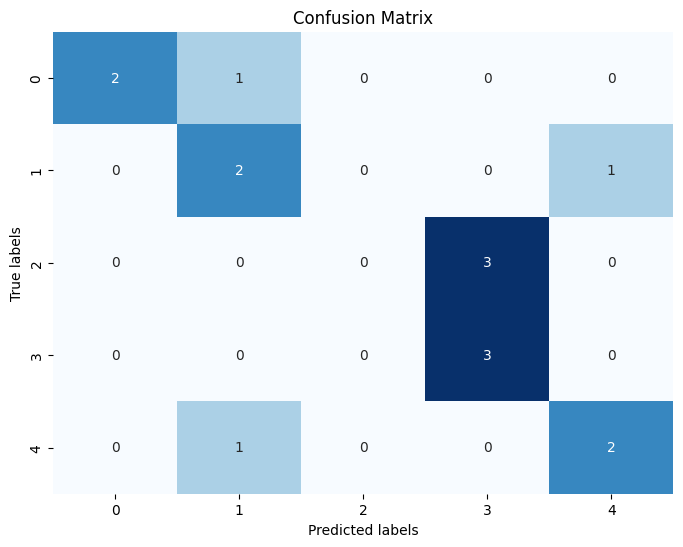

In [30]:
preds = []
real_preds = []
tt = None
pp = None
vacc = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader_1,
        train_data_loader_2,
        optimizer,
        device,
        scheduler
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss, predictions, val_logits, targets_arr = eval_model(
        model,
        val_data_loader_1,
        val_data_loader_2,
        device
    )
    if val_acc > vacc:
        tt = targets_arr
        pp = predictions
        vacc = val_acc

    # _, _, real_predictions, real_logits = eval_model(
    #     model,
    #     real_data_loader_1,
    #     real_data_loader_2,
    #     device
    # )

    # warnings.warn('val loss: '+str(val_loss)+'; valuation acc: '+str(val_acc))

    # print('tweets: ', X_test[:10])
    # print('pred: ', predictions[:10])
    # print('real: ', Y_test[:10])

    # warnings.warn('logits shape: '+str(real_logits.shape))
    # np.save('electra_distbert_sst2_gelu_'+str(tr)+'_'+str(epoch)+'_val_logits', val_logits)
    # np.save('electra_distbert_sst2_gelu_'+str(tr)+'_'+str(epoch)+'_real_logits', real_logits)

    # preds = [p if p==1 else -1 for p in predictions]
    # real_preds = [p if p==1 else -1 for p in real_predictions]

    # write test data to csv
    # with open('electra_distbert_sst2_gelu_'+str(tr)+'_'+str(epoch)+'_predictions.csv', 'w', newline='') as f:
    #     fieldnames = ['Id', 'Prediction']
    #     writer = csv.DictWriter(f, fieldnames=fieldnames)

    #     writer.writeheader()
    #     for j, p in enumerate(real_preds):
    #         writer.writerow({'Id':j+1, 'Prediction':p})

    print(f'Val loss {val_loss} Val accuracy {val_acc}')

cm = confusion_matrix(tt, pp)
print(classification_report(tt, pp))

# Create a heatmap plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Set plot labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# Display the plot
plt.show()